### determine basic camera sensitivity
* load data (gr: gain ref/bright field data, dr: dark reference)
* average data
* calculate mean counts per electron from gr, mean noise counts from dr

Package versions:<br>
python==3.10.8<br>
numpy==1.23.5<br>
matplotlib==3.6.2<br>
ipywidgets==8.0.4<br>

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [3]:
dr_data_folder = r"..\data\basic camera sensitivity\dark_ref"
gr_data_folder = r"..\data\basic camera sensitivity\counts"
data_folder = gr_data_folder.rsplit('\\',1)[0]
dr_data_name = r'\scan_data.raw'
gr_data_name = r'\scan_data.raw'
dr_data_info = r'\Report.txt'
gr_data_info = r'\Report.txt'

dr_data_path = dr_data_folder + dr_data_name
gr_data_path = gr_data_folder + gr_data_name
dr_data_info_path = dr_data_folder + dr_data_info
gr_data_info_path = gr_data_folder + gr_data_info

#t = 1/1000. # 1 ms 
I = 131.6*10**-12  #131.6 pA
e = 1.6021766208*10**-19 # As

In [4]:
def to_dict(data_info_path):
    """
    Read lines from a text file and convert them to a dict with 'Name': number (determines float or int). 
    Returns dict
    """
    f = open(data_info_path,'r')
    lines_org = f.readlines()[3:61]
    f.close()
    item_list = [e for e in lines_org if e not in ('\n')]
    d = {}
    for line in item_list:
        (key, val) = line.split()
        val = float(val)
        if val.is_integer():
            val = int(val)
        d[key] = val
    return d

In [5]:
dr_dict = to_dict(dr_data_info_path)
gr_dict = to_dict(gr_data_info_path)

In [6]:
dr_dict['cam_exposure_real']

999

In [7]:
t = gr_dict['cam_exposure_real'] # in µs
t

999

In [8]:
dr_scan_N = dr_dict['num_images']; dr_img_Nx = dr_dict['cam_width']; dr_img_Ny = dr_dict['cam_height']
gr_scan_N = gr_dict['num_images']; gr_img_Nx = gr_dict['cam_width']; gr_img_Ny = gr_dict['cam_height']
if dr_dict['cam_image_data_format'] == 5: dr_data_format = 'u1' 
if dr_dict['cam_image_data_format'] == 6: dr_data_format = '<u2'
if gr_dict['cam_image_data_format'] == 5: gr_data_format = 'u1' 
if gr_dict['cam_image_data_format'] == 6: gr_data_format = '<u2'

In [9]:
# load and average data
dr_data = np.fromfile(dr_data_path, dtype= dr_data_format, sep="")
dr_data = dr_data.reshape([dr_scan_N,dr_img_Nx, dr_img_Nx]).astype(float)
dr_data_shape = dr_data.shape


gr_data = np.fromfile(gr_data_path, dtype= gr_data_format, sep="")
gr_data = gr_data.reshape([gr_scan_N, gr_img_Nx, gr_img_Nx]).astype(float)
gr_data_shape = gr_data.shape

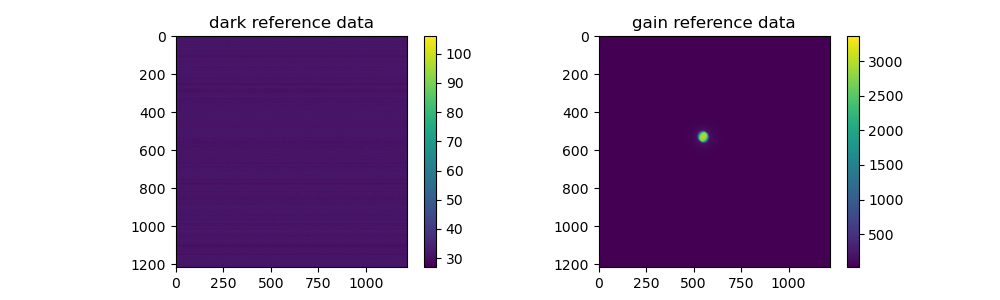

In [10]:
# plot data
num = 0
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,3))
im0 = ax0.imshow(dr_data[num,:,:])
ax0.set_title('dark reference data')
plt.colorbar(im0)

im1 = ax1.imshow(gr_data[num,:,:])
ax1.set_title('gain reference data')
plt.colorbar(im1)

In [11]:
# discard first image due to shift from beam blanker in gr data (do the same for dr data)
dr_data = dr_data[1:,:,:]
gr_data = gr_data[1:,:,:]

In [12]:
gr_data_mean = np.mean(gr_data, axis = 0)
dr_data_mean = np.mean(dr_data, axis = 0)
grmdr = gr_data_mean - dr_data_mean

# only consider counts larger than threshold when summing counts from electron beam
# could argue that this should be lower, but get a conservative estimate from that
threshold = np.max(gr_data_mean)/2.
grmdr_threshold = np.copy(grmdr)
grmdr_threshold[np.where(grmdr < threshold)] = 0

In [13]:
np.mean(dr_data)

31.29513033788654

In [14]:
np.std(dr_data)

0.9632062038493967

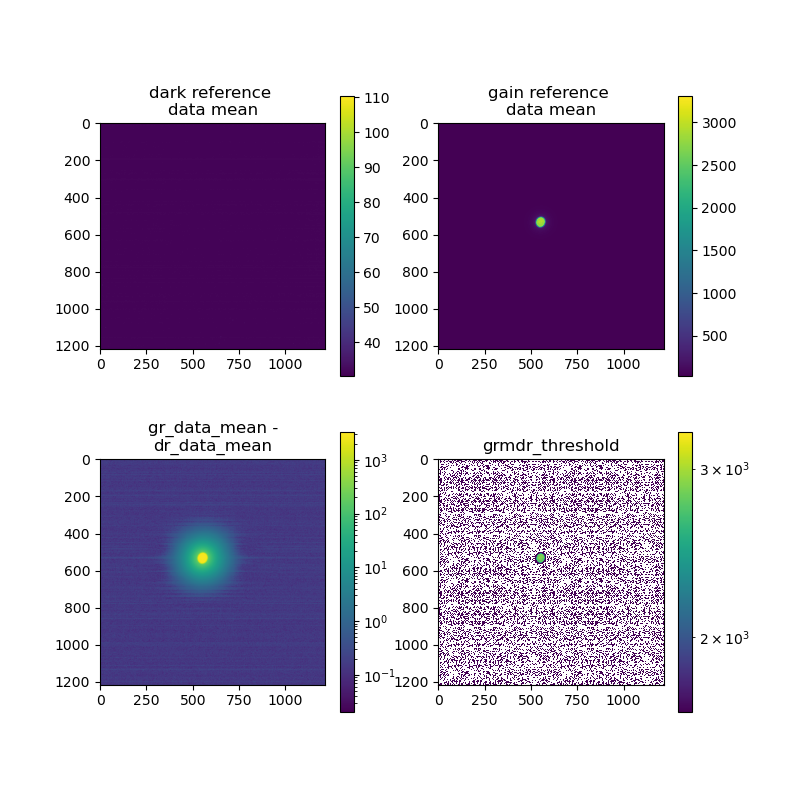

In [15]:
# plot data
num = 0
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2, ncols=2, figsize = (8,8))
im0 = ax0.imshow(dr_data_mean)
ax0.set_title('dark reference \ndata mean')
plt.colorbar(im0)

im1 = ax1.imshow(gr_data_mean)
ax1.set_title('gain reference \ndata mean')
plt.colorbar(im1)

im2 = ax2.imshow(np.abs(grmdr), norm = matplotlib.colors.LogNorm())
ax2.set_title('gr_data_mean -\ndr_data_mean')
plt.colorbar(im2)

im3 = ax3.imshow(grmdr_threshold, norm = matplotlib.colors.LogNorm())
ax3.set_title('grmdr_threshold')
plt.colorbar(im3)

In [16]:
# total counts without threshold applied
total_cam_counts_grmdr = np.sum(grmdr)
total_cam_counts_grmdr

7598714.734693878

In [17]:
# total counts with threshold applied
total_cam_counts = np.sum(grmdr_threshold)
total_cam_counts

5780965.775510204

In [18]:
t_s = t/(1000*1000) # camera exposure in sec
t_s

0.000999

In [19]:
A = 1/e
A # e/s

6.241509125883259e+18

In [20]:
total_e = I*t_s*A
total_e

820561.2183652706

In [21]:
total_cam_counts/total_e

7.04513648235423